В данной лабораторной работе предлагается познакомиться с архитектурой Vision Transformer (ViT) и обучить подобную модель на одной из баз MedMNIST.

[Блокнот](https://drive.google.com/file/d/1kAJXL3W--Kiym8SzVLBtP0RFZAW0o_3E/view?usp=sharing) взят из материалов курса [Introduction to Deep Learning Spring 2024](https://deeplearning.cs.cmu.edu/S24/index.html) Университета Карнеги — Меллона.

В лабораторной работе показан процесс реализации с нуля vision transformer (трансформера для компьютерного зрения) для набора данных MNIST.

Vision Transformer (ViT) был впервые представлен в 2020 году: https://arxiv.org/abs/2010.11929v2

**План**:
- Библиотеки
- Набор данных
- Токенизация
- Архитектура модели
  - Позиционное кодирование (Positional Encoding)
  - Механизм внимания (Attention)
  - Блок ViT (Add & Norm, Feed-Forward)
  - ViT энкодер
- Обучение
- Тестирование

[Комментарии к блокноту от авторов курса](https://www.youtube.com/watch?v=Dg5Zrxhhd6M)

# **Transformers (Part 2: Vision Transformer - ViT)**

# **Библиотеки**

In [1]:
!nvidia-smi

Wed May 28 00:37:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install torchinfo

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from tqdm.notebook import tqdm, trange
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchinfo import summary

import matplotlib.pyplot as plt
from IPython.display import clear_output
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Набор данных**

In [4]:
!pip install medmnist

clear_output()

In [5]:
from medmnist import ChestMNIST

In [6]:
batch_size = 128
imsize = 64

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = ChestMNIST(split="train", download=True, size=imsize, transform=transform)
test_set = ChestMNIST(split="test", download=True, size=imsize, transform=transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

100%|██████████| 402M/402M [00:41<00:00, 9.78MB/s]


# **Токенизация**
Процесс разделения входного изображения на меньшие, непересекающиеся фрагменты (патчи). Каждый патч служит токеном, который подвергается последующей обработке в архитектуре трансформера. Представление локализованных признаков: Изображения могут быть большими, и их попиксельная обработка в трансформерах была бы вычислительно затратной. Использование патчей позволяет трансформерам фокусироваться на меньших, локализованных областях, эффективно извлекая значимые признаки.

In [7]:
def patchify(images, n_patches):

    # Get the dimensions of the images
    num_images, channels, height, width = images.shape

    assert height == width, "Images must be square"

    # Initialize an empty list to store patches
    patches_list = []

    # Loop through patch indices
    for i in range(n_patches):
        for j in range(n_patches):
            # Extract the current patch from each image and flatten it
            patch = images[:, :, i * height // n_patches : (i + 1) * height // n_patches, j * width // n_patches : (j + 1) * width // n_patches].flatten(1)

            # Append the flattened patch to the list
            patches_list.append(patch)

    # Stack the patches along the specified dimension (dim=1)
    patches = torch.stack(patches_list, dim=1)

    return patches

# **Архитектура модели**

<img src="https://github.com/google-research/vision_transformer/raw/main/vit_figure.png" width="700">

## **Позиционное кодирование** (**Positional Encoding**)

In [8]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / d))) 
                if j % 2 == 0
                else np.cos(i / (10000 ** ((j - 1) / d)))
            )
    return result

## **Механизм внимания** (**Attention**)

In [9]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):

        super(MultiHeadSelfAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        assert self.head_dim * num_heads == d_model, "Invalid number of heads or d_model dimensions"

        # Linear mappings for queries, keys, and values
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)

        # Linear mapping for the output
        self.wo = nn.Linear(d_model, d_model)

    def forward(self, sequences, mask=None):

        batch_size, seq_length, _ = sequences.size()

        # Apply linear mappings for queries, keys, and values
        q = self.wq(sequences).view(batch_size, -1, self.num_heads, self.head_dim)
        k = self.wk(sequences).view(batch_size, -1, self.num_heads, self.head_dim)
        v = self.wv(sequences).view(batch_size, -1, self.num_heads, self.head_dim)

        # Transpose dimensions for compatibility with attention computation
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # Compute scaled dot-product attention
        attn = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)

        # Apply mask if provided
        if mask is not None:
            attn = attn.masked_fill(mask == 0, float('-inf'))

        # Apply softmax activation to obtain attention weights
        attn = F.softmax(attn, dim=-1)

        # Compute the weighted sum of values
        out = torch.matmul(attn, v).transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        # Apply linear mapping for the final output
        out = self.wo(out)

        return out

## **ViT блок (Add & Norm, Feed-Forward)**

In [10]:
class ViTBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads, mlp_ratio=4):

        super(ViTBlock, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        # Layer normalization for the Multi-Head Self Attention (MHSA) and the MLP
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.mhsa = MultiHeadSelfAttention(hidden_dim, num_heads)
        self.norm2 = nn.LayerNorm(hidden_dim)

        # Multi-Layer Perceptron (MLP) for feature transformation
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, mlp_ratio * hidden_dim),
            nn.GELU(),  # GELU activation function
            nn.Linear(mlp_ratio * hidden_dim, hidden_dim),
        )

    def forward(self, x):

        # Apply LayerNorm and Multi-Head Self Attention (MHSA)
        mhsa_out = self.mhsa(self.norm1(x))

        # Add the original input to the MHSA output (residual connection)
        out = x + mhsa_out

        # Apply LayerNorm and Multi-Layer Perceptron (MLP)
        mlp_out = self.mlp(self.norm2(out))

        # Add the original input to the MLP output (residual connection)
        out = out + mlp_out

        return out

## **ViT энкодер**

In [11]:
class ViT(nn.Module):
    def __init__(self, input_shape, n_patches=7, n_blocks=2, hidden_dim=8, n_heads=2, output_dim=10):

        # Super constructor
        super(ViT, self).__init__()

        # Attributes
        self.input_shape = input_shape  # (C, H, W)
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_dim = hidden_dim

        # Input and patches sizes
        assert (input_shape[1] % n_patches == 0), "Input shape not entirely divisible by the number of patches"
        assert (input_shape[2] % n_patches == 0), "Input shape not entirely divisible by the number of patches"

        self.patch_size = (input_shape[1] / n_patches, input_shape[2] / n_patches)

        # 1) Linear mapper
        self.input_dim = int(input_shape[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_dim, hidden_dim)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, hidden_dim))

        # 3) Positional embedding
        self.register_buffer("positional_embeddings",get_positional_embeddings(n_patches**2 + 1, hidden_dim),
            persistent=False)

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([ViTBlock(hidden_dim, n_heads)] * n_blocks)

        # 5) Classification MLP
        self.mlp = nn.Sequential(nn.Linear(hidden_dim, output_dim), nn.Softmax(dim=-1))

    def forward(self, images):

        # Dividing images into patches
        batch_size, _, _, _ = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(batch_size, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(batch_size, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)  # Map to output dimension, output category distribution

# **Обучение**

In [12]:
# Define Hyperparameters
N_EPOCHS = 50
LR = 0.005
BATCH_SIZE = 128
N_PATCHES = 8
N_BLOCKS = 2
HIDDEN_DIM = 8
N_HEADS = 2
OUTPUT_DIM = 14

In [13]:
# Model summary
model = ViT((1, 64, 64), N_PATCHES, N_BLOCKS, HIDDEN_DIM, N_HEADS, OUTPUT_DIM).to(device)
summary(model, input_size=(1, 1, 64, 64))

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 14]                   8
├─Linear: 1-1                                 [1, 64, 8]                520
├─ModuleList: 1-2                             --                        --
│    └─ViTBlock: 2-1                          [1, 65, 8]                --
│    │    └─LayerNorm: 3-1                    [1, 65, 8]                16
│    │    └─MultiHeadSelfAttention: 3-2       [1, 65, 8]                288
│    │    └─LayerNorm: 3-3                    [1, 65, 8]                16
│    │    └─Sequential: 3-4                   [1, 65, 8]                552
│    └─ViTBlock: 2-2                          [1, 65, 8]                (recursive)
│    │    └─LayerNorm: 3-5                    [1, 65, 8]                (recursive)
│    │    └─MultiHeadSelfAttention: 3-6       [1, 65, 8]                (recursive)
│    │    └─LayerNorm: 3-7                    [1, 65, 8]          

In [14]:
 # Training loop
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y = y.argmax(dim=1)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 1/50 loss: 2.12


Epoch 2 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 2/50 loss: 2.11


Epoch 3 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 3/50 loss: 2.11


Epoch 4 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 4/50 loss: 2.11


Epoch 5 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 5/50 loss: 2.11


Epoch 6 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 6/50 loss: 2.11


Epoch 7 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 7/50 loss: 2.11


Epoch 8 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 8/50 loss: 2.11


Epoch 9 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 9/50 loss: 2.11


Epoch 10 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 10/50 loss: 2.11


Epoch 11 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 11/50 loss: 2.11


Epoch 12 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 12/50 loss: 2.11


Epoch 13 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 13/50 loss: 2.11


Epoch 14 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 14/50 loss: 2.11


Epoch 15 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 15/50 loss: 2.11


Epoch 16 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 16/50 loss: 2.11


Epoch 17 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 17/50 loss: 2.11


Epoch 18 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 18/50 loss: 2.11


Epoch 19 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 19/50 loss: 2.11


Epoch 20 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 20/50 loss: 2.11


Epoch 21 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 21/50 loss: 2.11


Epoch 22 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 22/50 loss: 2.11


Epoch 23 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 23/50 loss: 2.11


Epoch 24 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 24/50 loss: 2.11


Epoch 25 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 25/50 loss: 2.11


Epoch 26 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 26/50 loss: 2.11


Epoch 27 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 27/50 loss: 2.11


Epoch 28 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 28/50 loss: 2.11


Epoch 29 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 29/50 loss: 2.11


Epoch 30 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 30/50 loss: 2.11


Epoch 31 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 31/50 loss: 2.11


Epoch 32 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 32/50 loss: 2.11


Epoch 33 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 33/50 loss: 2.11


Epoch 34 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 34/50 loss: 2.11


Epoch 35 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 35/50 loss: 2.11


Epoch 36 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 36/50 loss: 2.11


Epoch 37 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 37/50 loss: 2.11


Epoch 38 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 38/50 loss: 2.11


Epoch 39 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 39/50 loss: 2.11


Epoch 40 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 40/50 loss: 2.11


Epoch 41 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 41/50 loss: 2.11


Epoch 42 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 42/50 loss: 2.11


Epoch 43 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 43/50 loss: 2.11


Epoch 44 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 44/50 loss: 2.11


Epoch 45 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 45/50 loss: 2.11


Epoch 46 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 46/50 loss: 2.11


Epoch 47 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 47/50 loss: 2.11


Epoch 48 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 48/50 loss: 2.11


Epoch 49 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 49/50 loss: 2.11


Epoch 50 in training:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 50/50 loss: 2.11


# **Тестирование**

In [15]:
# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y = y.argmax(dim=1)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Testing:   0%|          | 0/176 [00:00<?, ?it/s]

Test loss: 2.12
Test accuracy: 63.96%


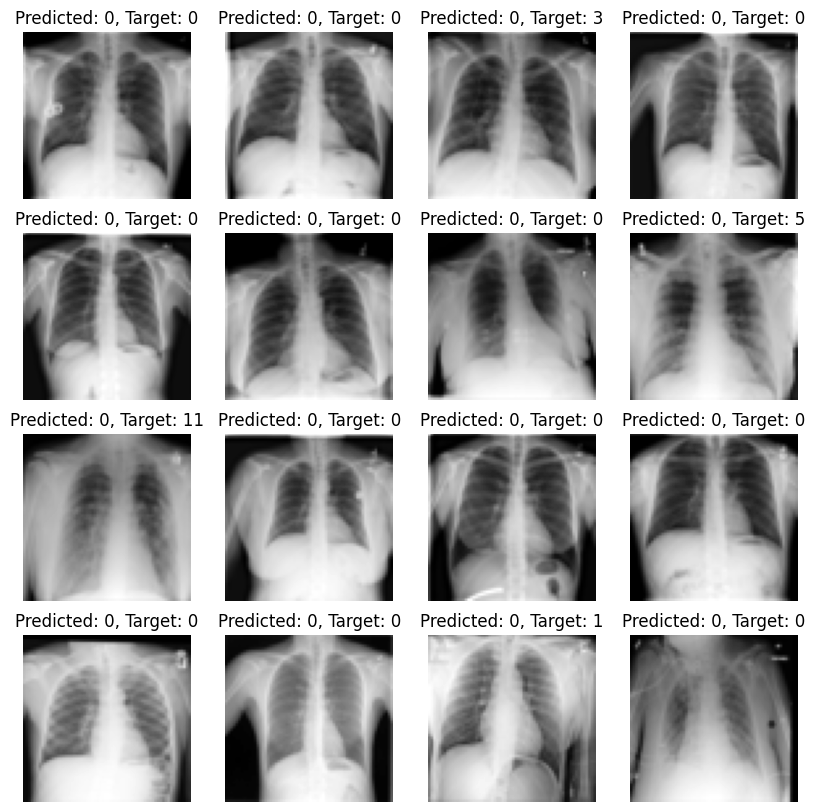

In [16]:
# Show some predictions
with torch.no_grad():
    x, y = next(iter(test_loader))
    x, y = x.to(device), y.to(device)
    y = y.argmax(dim=1)
    y_hat = model(x)
    y_hat = torch.argmax(y_hat, dim=1)

    fig, axs = plt.subplots(4, 4, figsize=(10, 10))
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(x[i * 4 + j].cpu().view(64, 64), cmap="gray")
            axs[i, j].set_title(f"Predicted: {y_hat[i * 4 + j]}, Target: {y[i * 4 + j]}")
            axs[i, j].axis("off")
    plt.show()

#### В данной лабораторной работе была реализована и исследована архитектура Vision Transformer для классификации изображений из набора данных MNIST. Результаты тестирования показали, что модель достигла точности 63.96% при значении функции потерь 2.12 на тестовой выборке. Анализ предсказаний модели выявил, что она склонна чаще предсказывать класс "0", даже в случаях, когда правильными ответами были другие цифры 1, 3, 5 или 11. Это может свидетельствовать о недостаточной сбалансированности данных или необходимости дополнительной настройки гиперпараметров модели.Реализация включала все ключевые компоненты ViT: токенизацию изображений, позиционное кодирование, механизм внимания и полносвязные слои. Хотя модель продемонстрировала работоспособность, её точность оказалась ниже, чем у традиционных сверточных нейронных сетей.